In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from autogluon.tabular import TabularDataset, TabularPredictor

from sklearn.model_selection import KFold
from scipy.stats import beta
from scipy.optimize import fmin

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

Some parts of the below code inspired from 
https://www.kaggle.com/code/cdeotte/nn-starter-lb-72300-cv-72800

In [59]:
def cleanse_data(train, test):

    test['price'] = 0
    # train['price'] = np.log(train['price'])
    train_len = len(train)
    train = pd.concat((train, test), axis=0, ignore_index=True)

    numerical_features = ['milage']
    categorical_features = [i for i in train.columns if i not in numerical_features and not i == 'price']

    # Standardize numerical features
    for i in numerical_features:
        train[i] = np.log(train[i])
        mean_val = train[i].mean()
        std_val = train[i].std()
        train[i] = train[i].apply(lambda x: (x-mean_val)/std_val)
        train[i] = train[i].fillna(mean_val)
    # train['milage'] = (train['milage']-min(train['milage']))/(max(train['milage'])-min(train['milage']))
    # a, b = beta.fit(train['milage'])


    for i in categorical_features:
        
        # train[i].fillna('None')

        # avg_price_by_model = train.groupby('model')['price'].mean()

        # # Create a new column with the encoded values
        # train['model'] = train['model'].map(avg_price_by_model)

        # If there are any models in the test set that weren't in the training set,
        # you might want to fill those with the overall average price
        # overall_avg_price = train['price'].mean()
        # train['model'].fillna(overall_avg_price, inplace=True)
        
        # # Calculate the average price for each model
        avg_price = train.groupby(i)['price'].mean()

        # Sort models by average price
        sorted_models = avg_price.sort_values().index

        # Create a mapping from model to label
        model_to_label = {model: label for label, model in enumerate(sorted_models)}

        # Label encode the 'model' column
        train[i] = train[i].map(model_to_label)
    
    test = train[train_len:]
    train = train[:train_len]

    return train, test

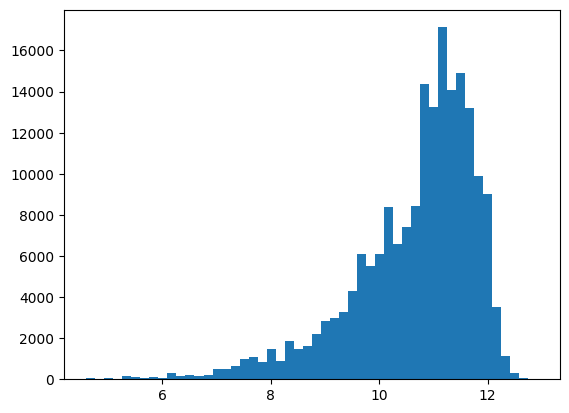

In [60]:
plt.hist(np.log(train['milage']), bins=50)
plt.show()

In [61]:
# kf = KFold(n_splits=5, random_state=42, shuffle=True)

# for i, (train_index, test_index) in enumerate(kf.split(train)):
#     print("Fold: ", i+1)
#     print("Train index: ", train_index)
#     print("Test index: ", test_index)

train_data, test_data = cleanse_data(train, test)

test_id = test['id']

# print(train_data.head())
# print(test_data.head())

train_data = TabularDataset(train_data.drop(columns='id'))
test_data = TabularDataset(test_data.drop(columns='id'))

In [62]:
# from autogluon.tabular import TabularDataset, TabularPredictor

# # test_id = test_data['id']

# if type(train_data) is not TabularDataset:
#     train_data = TabularDataset(train_data.drop(columns='id'))
#     test_data = TabularDataset(test_data.drop(columns='id'))
    
TRAIN_LN = int(0.8*len(train_data))
valid_data = train_data[TRAIN_LN:]
train_data = train_data[:TRAIN_LN]

params = {
	'GBM': [{'extra_trees': True, 'ag_args': {'name_suffix': 'XT'}}, {}, 'GBMLarge'],
	'CAT': {},
	'XGB': {},
	'RF': [{'criterion': 'gini', 'ag_args': {'name_suffix': 'Gini', 'problem_types': ['binary', 'multiclass']}}, {'criterion': 'entropy', 'ag_args': {'name_suffix': 'Entr', 'problem_types': ['binary', 'multiclass']}}, {'criterion': 'squared_error', 'ag_args': {'name_suffix': 'MSE', 'problem_types': ['regression', 'quantile']}}],
	'XT': [{'criterion': 'gini', 'ag_args': {'name_suffix': 'Gini', 'problem_types': ['binary', 'multiclass']}}, {'criterion': 'entropy', 'ag_args': {'name_suffix': 'Entr', 'problem_types': ['binary', 'multiclass']}}, {'criterion': 'squared_error', 'ag_args': {'name_suffix': 'MSE', 'problem_types': ['regression', 'quantile']}}],
	'KNN': [{'weights': 'uniform', 'ag_args': {'name_suffix': 'Unif'}}, {'weights': 'distance', 'ag_args': {'name_suffix': 'Dist'}}],
}
predictor = TabularPredictor(label='price', problem_type='regression').fit(train_data=train_data, hyperparameters=params)
predictions = predictor.predict(test_data)

No path specified. Models will be saved in: "AutogluonModels\ag-20240912_110707"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.9.7
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          8
Memory Avail:       6.04 GB / 15.85 GB (38.1%)
Disk Space Avail:   349.45 GB / 475.76 GB (73.5%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial proto

[1000]	valid_set's rmse: 95769.3


	-95721.7887	 = Validation score   (-root_mean_squared_error)
	3.77s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: LightGBM ...
	-96533.0243	 = Validation score   (-root_mean_squared_error)
	0.6s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-101798.061	 = Validation score   (-root_mean_squared_error)
	41.52s	 = Training   runtime
	0.09s	 = Validation runtime
Fitting model: CatBoost ...
	-96122.6837	 = Validation score   (-root_mean_squared_error)
	1.97s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-99302.9674	 = Validation score   (-root_mean_squared_error)
	14.31s	 = Training   runtime
	0.09s	 = Validation runtime
Fitting model: XGBoost ...
	-95980.4184	 = Validation score   (-root_mean_squared_error)
	0.87s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBMLarge ...
	-97097.9413	 = Validation score   (-root_mean_squared_error)
	1.32s	 = Training   runtime
	0.01s

In [63]:
# predictor = TabularPredictor.load("AutogluonModels/ag-20240911_021401")
# predictor.evaluate(test_data)
# predictor.leaderboard(test_data)

from sklearn.metrics import root_mean_squared_error
predictions = predictor.predict(test_data)
predictions_valid = predictor.predict(valid_data.drop(columns='price'))

# predictions = np.exp(predictions)

# print(predictions.head())

rmse_val = root_mean_squared_error(np.exp(valid_data['price']), np.exp(predictions_valid))
print(rmse_val)

# result = pd.concat((test_id, predictions), axis=1)

predictions.to_csv('result.csv', index=True)


c:\Users\diamo\anaconda3\envs\tf\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: Input contains infinity or a value too large for dtype('float64').